## 2.A detailed notebook containing all the statistical operations and form various kinds of plots depicting the data

In [137]:

import regex as re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from collections import Counter

In [138]:
#open the file
df = pd.read_csv('ds.csv')

In [139]:
df.head()

,session,year,country,country_name,speaker,position,text
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ..."


In [140]:
#checking for null
df.isnull().sum()

session            0
year               0
country            0
country_name       0
speaker           27
position        3005
text               0
dtype: int64

In [141]:
#summary statistics
df.describe()

,session,year
count,7507.000000,7507.000000
mean,49.610763,1994.610763
std,12.892155,12.892155
min,25.000000,1970.000000
25%,39.000000,1984.000000
50%,51.000000,1996.000000
75%,61.000000,2006.000000
max,70.000000,2015.000000


### Charts

In [142]:
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
print(stopwords)

{'as', 'won', 'myself', "needn't", 'hadn', 'these', 'through', 're', "aren't", 'am', 'those', 'shan', 'hasn', 've', 'over', 'are', 'having', 'herself', "don't", "doesn't", 'my', 'who', 'yours', 'himself', 'me', 'below', 'm', 'any', 'until', 'there', "you're", 't', "you've", 'some', "mustn't", 'up', 'which', 'she', 'just', 'its', 'how', 'against', 'and', 'while', 's', 'this', 'few', 'haven', 'ma', 'can', 'i', "should've", 'again', 'mustn', 'wouldn', 'what', 'being', 'to', "she's", 'further', 'they', 'him', 'by', 'our', 'off', 'more', 'been', 'with', 'mightn', 'doesn', 'same', 'other', "isn't", 'or', "you'll", 'out', 'all', "weren't", 'but', "mightn't", "hadn't", 'have', 'd', 'at', 'nor', 'weren', 'on', 'down', 'both', 'did', 'theirs', 'than', 'y', 'very', 'such', 'during', 'in', 'itself', 'were', 'most', "shouldn't", 'her', 'the', 'll', "wouldn't", 'be', 'for', 'where', 'don', 'should', "didn't", 'is', "hasn't", 'hers', 'too', 'only', "shan't", 'when', 'because', 'now', 'isn', 'above', 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.Use regex to remove stop words. 

In [143]:
def tokenize(text):
    return re.findall(r'[\w-]*[a-z|A-Z][\w-]*', text)

In [144]:
def clean_session(session):
    return session

### Removing Stop words

In [145]:
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Remove @mentions
    text = re.sub(r'#', '', text) # Remove the '#' symbol
    text = re.sub(r'RT[\s]+', '', text) # Remove RT
    text = re.sub(r'https?:\/\/\S+', '', text) # Remove hyperlinks
    text = re.sub(r':', '', text) # Remove colons
    text = re.sub(r'[!\'.,]','',text) # Remove punctuation
    return text


In [146]:
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]
pipeline = [str.lower, tokenize, remove_stop]

### 3. Create Pipeline, remove stop words, word frequency analysis and word clouds

In [147]:
def prepare(text, pipeline):
    tokens = text
    for fun in pipeline:tokens = fun(tokens)
    return tokens
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)

In [148]:
counter = Counter()
df['tokens'].map(counter.update)
freq_df = pd.DataFrame.from_dict(counter, orient='index',columns=['freq'])
freq_df = freq_df.query('freq >= 1')
freq_df.index.name = 'token'
freq_df = freq_df.sort_values('freq', ascending=False)
freq_df.head(10)

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734
peace,72625
development,62632
states,59713
people,59338


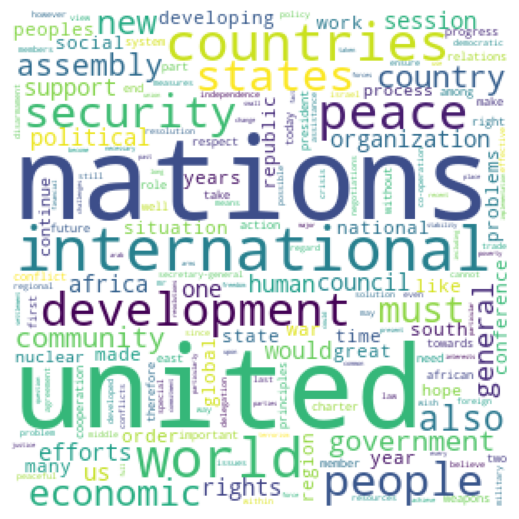

In [149]:
wc = WordCloud(background_color='white', width = 300, height=300, margin=2)
wc.fit_words(freq_df['freq'].to_dict() )
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [150]:
def compute_idf(df, column='tokens', preprocess=None, min_df=1):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))
    counter = Counter()
    df[column].map(update)# create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df
idf_df = compute_idf(df)

In [151]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']
freq_df.head()

,freq,tfidf
token,,
nations,124508,12649.986284
united,120763,12285.608632
international,117223,12364.276226
world,89421,9503.708982
countries,85734,10888.485986


### Displaying Matplot

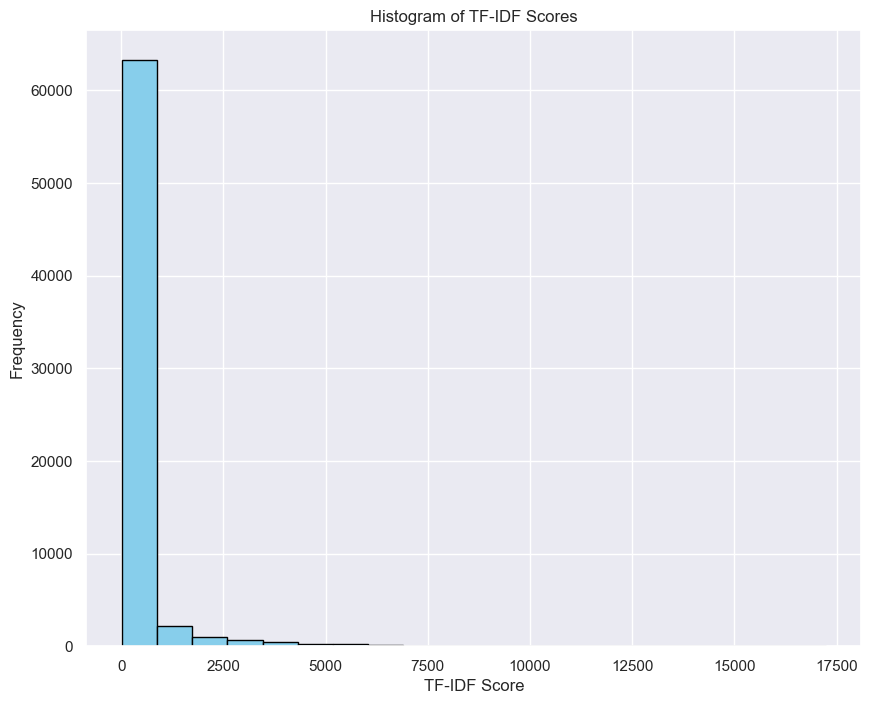

In [152]:
# Assuming freq_df is your DataFrame with columns 'word', 'freq', and 'tfidf'
# Plotting a histogram for the 'tfidf' column
plt.figure(figsize=(10, 8))
plt.hist(freq_df['tfidf'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of TF-IDF Scores')
plt.xlabel('TF-IDF Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### using sns

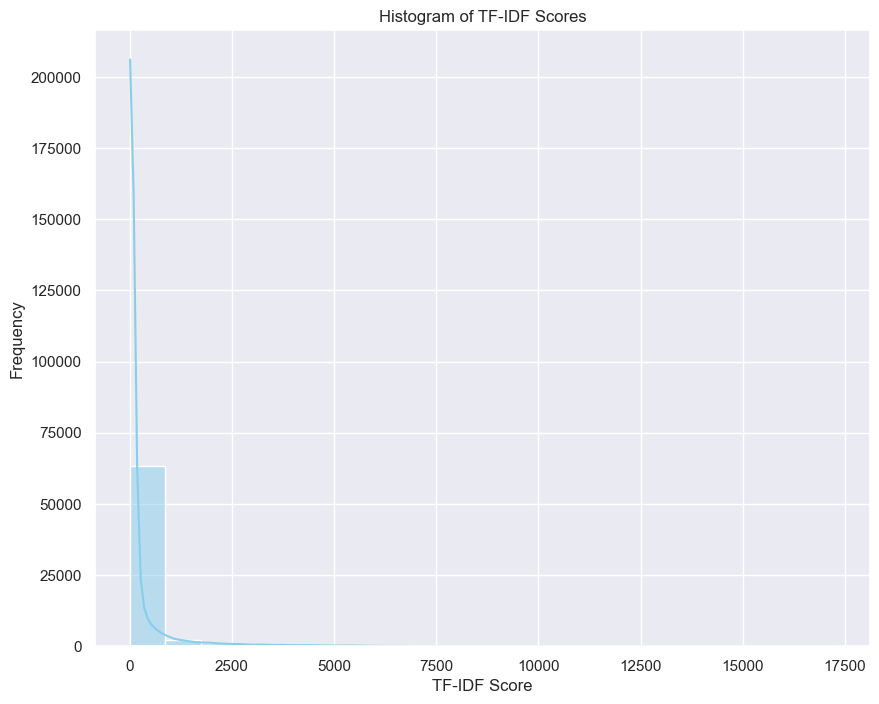

In [153]:
# Assuming freq_df is your DataFrame with columns 'word', 'freq', and 'tfidf'
# Plotting a histogram for the 'tfidf' column
plt.figure(figsize=(10, 8))
sns.histplot(freq_df['tfidf'], bins=20, color='skyblue', kde=True)
plt.title('Histogram of TF-IDF Scores')
plt.xlabel('TF-IDF Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Charts

In [154]:
df['length'] = df['text'].str.len()

### Histogram

<Axes: ylabel='Frequency'>

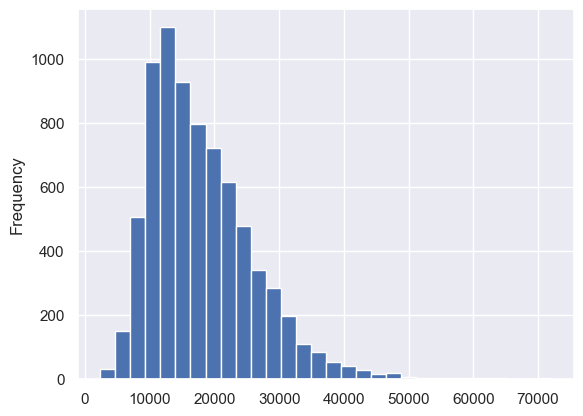

In [155]:
df['length'].plot(kind='hist', bins=30)

### Boxplot

<Axes: >

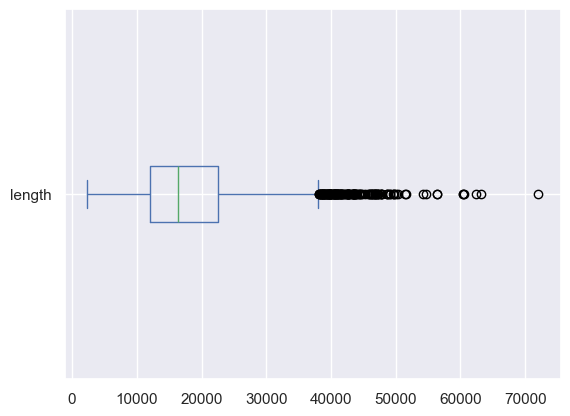

In [156]:
df['length'].plot(kind='box', vert=False)

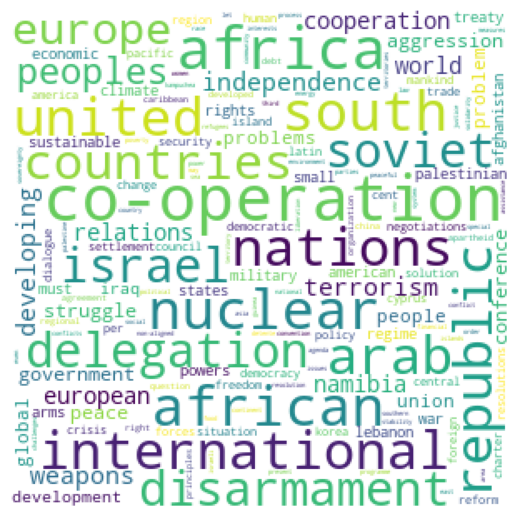

In [157]:
wc = WordCloud(background_color='white', width = 300, height=300,margin=2)
wc.fit_words(freq_df['tfidf'].to_dict() )
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

## Adding Token Count and Keyword Counter to DataFrame

In [158]:
df['num_tokens'] = df['tokens'].map(len)
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

### Count Keywords by Grouping Column

In [159]:
def count_keywords_by(df, by, keywords, column='tokens'):
    df = df.reset_index(drop=True) # if the supplied dataframe has gaps inthe index
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix,columns=keywords)
    freq_df[by] = df[by] # copy the grouping column(s)
    return freq_df.groupby(by=by).sum().sort_values(by)

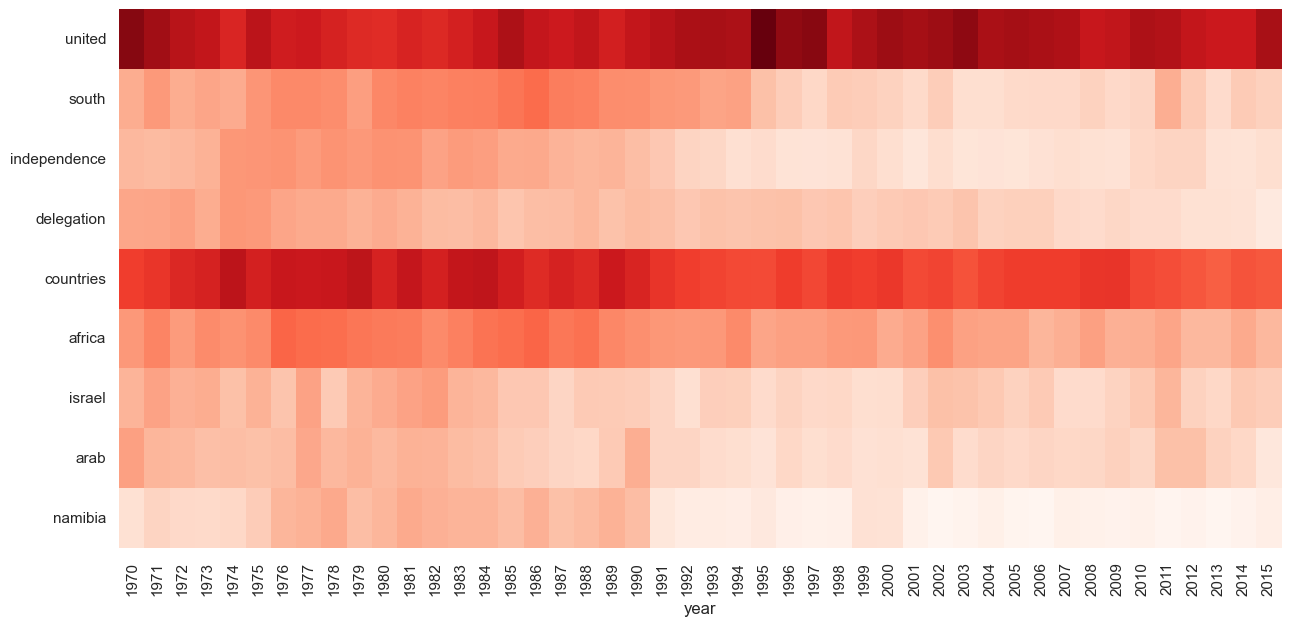

In [160]:
keywords = ['united','south','independence','delegation','countries','africa','israel','arab','namibia']
freq_df = count_keywords_by(df, by='year', keywords=keywords)
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)
freq_df = freq_df.apply(np.sqrt)
# Plotting the heatmap
plt.figure(figsize=(15, 7))
sns.set(font_scale=1)
sns.heatmap(data=freq_df.T,xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")
sns.set(font_scale=1)

### 5. Sentiment analysis.

In [175]:
from textblob import TextBlob

In [176]:
#Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#Create a function to get Polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

#Now we create a new column for what we just did and add it to the Tweet_df dataframe
df['Subjectivity'] = df['text'].apply(getSubjectivity)
df['Polarity'] = df['text'].apply(getPolarity)

#Now display data
df.head()

,session,year,country,country_name,speaker,position,text,tokens,length,num_tokens,Subjectivity,Polarity,Insight
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...,"[may, first, convey, president, congratulation...",51419,4092,0.428103,0.116178,Positive
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...,"[fortunate, coincidence, precisely, time, unit...",29286,2341,0.420252,0.093982,Positive
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...,"[pleasure, extend, mr, president, warmest, con...",31839,2575,0.427271,0.096576,Positive
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...,"[may, begin, expressing, ambassador, hambro, b...",26616,2166,0.383805,0.120814,Positive
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ...","[doubt, us, coming, rostrum, wonders, usefulne...",25911,2064,0.390931,0.119947,Positive


In [182]:
df.tail()

,session,year,country,country_name,speaker,position,text,tokens,length,num_tokens,Subjectivity,Polarity,Insight
7502,70,2015,YEM,Yemen,Mr. Abdrabuh Mansour Hadi Mansour,President,On behalf of the people and the Government of ...,"[behalf, people, government, yemen, would, lik...",10568,894,0.413363,0.197261,Positive
7503,70,2015,YUG,Yugoslavia,Mr. Tomislav Nikolić,President,\nSeventy years have passed since the establis...,"[seventy, years, passed, since, establishment,...",25430,2118,0.454976,0.090815,Positive
7504,70,2015,ZAF,South Africa,Jacob Zuma,President,I should like to congratulate the President an...,"[like, congratulate, president, country, denma...",13662,1160,0.400617,0.108256,Positive
7505,70,2015,ZMB,Zambia,Mr. Edgar Chagwa Lungu,President,I would like to begin by thanking the Secretar...,"[would, like, begin, thanking, secretary-gener...",14247,1197,0.462402,0.154233,Positive
7506,70,2015,ZWE,Zimbabwe,Robert Mugabe,President,Allow me at the outset to extend to Mr. Mogens...,"[allow, outset, extend, mr, mogens, lykketoft,...",11013,903,0.434626,0.102123,Positive


### Generating Insight from Polarity Score

In [183]:
def getInsight(score):
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"
    
df["Insight"] = df["Polarity"].apply(getInsight)

df.head(50)

,session,year,country,country_name,speaker,position,text,tokens,length,num_tokens,Subjectivity,Polarity,Insight
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...,"[may, first, convey, president, congratulation...",51419,4092,0.428103,0.116178,Positive
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...,"[fortunate, coincidence, precisely, time, unit...",29286,2341,0.420252,0.093982,Positive
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...,"[pleasure, extend, mr, president, warmest, con...",31839,2575,0.427271,0.096576,Positive
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...,"[may, begin, expressing, ambassador, hambro, b...",26616,2166,0.383805,0.120814,Positive
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ...","[doubt, us, coming, rostrum, wonders, usefulne...",25911,2064,0.390931,0.119947,Positive
5,25,1970,BLR,Belarus,Mr. GURINOVICH,NaN,\n71.\t. We are today mourning the untimely de...,"[today, mourning, untimely, death, president, ...",35181,2829,0.383427,0.125431,Positive
6,25,1970,BOL,"Bolivia, Plurinational State of",Mr. CAMACHO OMISTE,NaN,135.\t I wish to congratulate the President o...,"[wish, congratulate, president, well-deserved,...",31824,2543,0.443364,0.089124,Positive
7,25,1970,BRA,Brazil,Mr. GIBSON BARBOZA,NaN,"1.\tMr. President, I should like, first of all...","[mr, president, like, first, congratulate, una...",24489,1964,0.405469,0.075825,Positive
8,25,1970,CAN,Canada,Mr. SHARP,NaN,\nThe General Assembly is fortunate indeed to ...,"[general, assembly, fortunate, indeed, preside...",10518,878,0.435053,0.107194,Positive
9,25,1970,CMR,Cameroon,Mr. AHIDJO,President,: A year ago I came here as the Acting Preside...,"[year, ago, came, acting, president, organizat...",17415,1387,0.408510,0.125658,Positive


In [184]:
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Plot the values count of sentiment

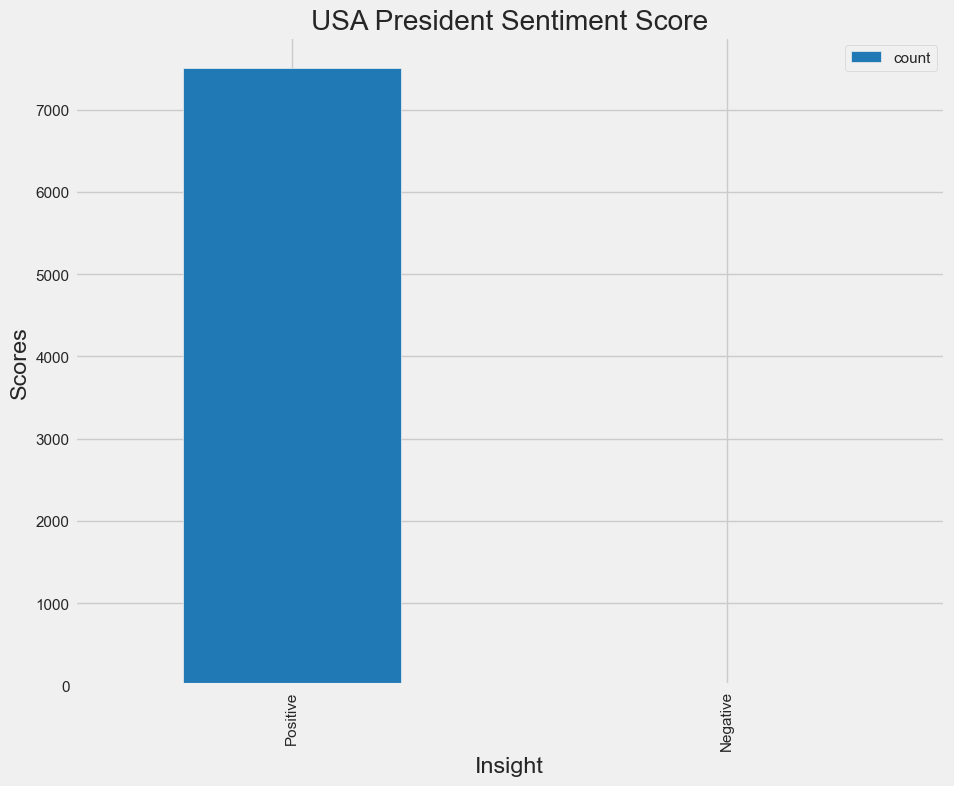

In [185]:

plt.title("USA President Sentiment Score")
plt.xlabel("Sentiment")
plt.ylabel("Scores")
plt.rcParams["figure.figsize"] = (10,8)
df["Insight"].value_counts().plot(kind="bar", color="#2078B4")
plt.legend()
plt.show()


## 4. Pick 5 random strings which we will encounter in our day-to-day life as a data scientist and write regex to identify them and sort, provide an example and result of the regex for each string.

In [186]:
import re

# i. Email addresses

In [187]:

email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
email_text = "Contact us at info@example.com or support@example.net for assistance."
email_matches = re.findall(email_pattern, email_text)
print("Email addresses found:", email_matches)


Email addresses found: ['info@example.com', 'support@example.net']


## ii. Phone numbers


In [188]:
phone_pattern = r'\(?(\d{3})\)?[\s-]?\d{3}[\s-]?\d{4}'
phone_text = "Call us at (123) 456-7890 for inquiries or support."
phone_matches = re.findall(phone_pattern, phone_text)
print("Phone numbers found:", phone_matches)

Phone numbers found: ['123']


## iii. URLs

In [189]:
# URLs
url_pattern = r'(https?://)?(?:www\.)?([a-zA-Z0-9-]+)(\.[a-zA-Z]{2,})(/\S*)?'
url_text = "Visit our website at https://www.example.com for more information."
url_matches = re.findall(url_pattern, url_text)
print("URLs found:", [''.join(match) for match in url_matches])


URLs found: ['https://example.com']


## iv. Dates (in MM/DD/YYYY format)

In [190]:

date_pattern = r'(0[1-9]|1[0-2])/(0[1-9]|[12][0-9]|3[01])/(19|20)\d{2}'
date_text = "The event is scheduled for 12/31/2022. Don't miss it!"
date_matches = re.findall(date_pattern, date_text)
print("Dates found:", ['/'.join(date) for date in date_matches])


Dates found: ['12/31/20']


## V. Credit card numbers

In [191]:


credit_card_pattern = r'\b(?:\d[ -]*?){13,16}\b'
credit_card_text = "Please provide your credit card number: 1234-5678-9012-3456"
credit_card_matches = re.findall(credit_card_pattern, credit_card_text)
print("Credit card numbers found:", credit_card_matches)

Credit card numbers found: ['1234-5678-9012-3456']
